<a href="https://colab.research.google.com/github/Swastik200/30DaysOfDSA/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/CMAPSS.zip" "/content"
!unzip CMAPSS.zip

Archive:  CMAPSS.zip
  inflating: CMAPSS/readme.txt       
  inflating: CMAPSS/RUL_FD001.txt    
  inflating: CMAPSS/RUL_FD002.txt    
  inflating: CMAPSS/RUL_FD003.txt    
  inflating: CMAPSS/RUL_FD004.txt    
  inflating: CMAPSS/test_FD001.txt   
  inflating: CMAPSS/test_FD002.txt   
  inflating: CMAPSS/test_FD003.txt   
  inflating: CMAPSS/test_FD004.txt   
  inflating: CMAPSS/train_FD001.txt  
  inflating: CMAPSS/train_FD002.txt  
  inflating: CMAPSS/train_FD003.txt  
  inflating: CMAPSS/train_FD004.txt  
  inflating: CMAPSS/x.txt            


In [4]:
import random
import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Flatten
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [7]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [8]:
path = '/content/CMAPSS/'
df_train = pd.read_csv(path+'train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names) #\s表示以空白為間隔
df_test = pd.read_csv(path+'test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_test = pd.read_csv(path+'RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
y_test.shape

(100, 1)

In [9]:
train = df_train.copy()
test = df_test.copy()
display(train)
display(test)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [10]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the test dataset : ',test.shape)

Shape of the train dataset :  (20631, 26)
Shape of the test dataset :  (13096, 26)


In [11]:
def process_targets(data_length, early_rul):
  early_rul_duration = data_length - early_rul # 壽命比early rul 多了多長
  if early_rul_duration <= 0: # 如果壽命小於early rul，targets則不變
    return np.arange(data_length-1, -1, -1)
  else:
    new_early_rul = early_rul * np.ones(early_rul_duration) # 多出多少early rul
    origin_rul = np.arange(early_rul-1, -1, -1)
    return np.append(new_early_rul,origin_rul)

In [12]:

def process_input_data_with_targets(input_data, target_data , window_length , shift ):
  num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1 # 共有多少組小資料
  num_features = input_data.shape[1] # 每筆資料的特徵數
  output = np.repeat(np.nan, repeats = num_batches * window_length * num_features)
  output_data = output.reshape(num_batches, window_length , num_features)

  if target_data is None: #測試資料無target data
    for batch in range(num_batches):
      output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
    return output_data
  else : #處理訓練資料的target data
    output_targets = np.repeat(np.nan, repeats = num_batches) #target rul
    for batch in range(num_batches):
      window_start = shift * batch
      window_end = window_start + window_length

      output_data[batch,:,:] = input_data[window_start:window_end,:]
      output_targets[batch] = target_data[window_end-1]
    return output_data, output_targets

In [13]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):

    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1 #共有多少組小資料

    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                          target_data = None,
                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                          target_data = None,
                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [14]:
drop_labels = ['sensor_1', 'sensor_5','sensor_6','sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train_data_first_column = train["unit_number"]
test_data_first_column = test["unit_number"]

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train.drop(columns = ['unit_number'] + setting_names + drop_labels ))
test_data = scaler.transform(test.drop(columns = ['unit_number'] + setting_names+ drop_labels ))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

In [15]:
window_length = 30
shift = 1
early_rul = 125
num_test_windows = 5

In [16]:

processed_train_data = []
processed_train_targets = []

for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values #每台機器的資料

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,window_length= window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [17]:

processed_test_data = []
num_test_windows_list = []

for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift = shift,num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = y_test.values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [18]:
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 15)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 15)
True RUL shape:  (100, 1)


In [19]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                        processed_train_targets,
                                                        test_size = 0.2,
                                                        random_state = 666)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 15)
Processed validation data shape:  (3547, 30, 15)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [20]:
def LSTM_model():
  input_shape = (window_length, 15)
  model = Sequential([
    layers.LSTM(128, input_shape = input_shape , activation = "tanh"),
    layers.Dense(96, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1)
  ])
  model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

LSTM_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73728     
                                                                 
 dense (Dense)               (None, 96)                12384     
                                                                 
 dense_1 (Dense)             (None, 128)               12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 98657 (385.38 KB)
Trainable params: 98657 (385.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.0001

In [22]:
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)
batch_size = 50
epoch = 20
kernel_size = 3
pool_size = 2


In [23]:
lstm_model = LSTM_model()

In [24]:
models = {"LSTM":lstm_model}

In [25]:
def evaluate(true_rul ,pred_rul, model):
  MAE = mean_absolute_error(true_rul, pred_rul)
  RMSE = np.sqrt(mean_squared_error(true_rul, pred_rul))
  r2 = r2_score(true_rul, pred_rul)
  print("Testing : R-square = ",r2,'MAE = ',MAE,"RMSE = ", RMSE)

In [26]:
history_train_loss = []
history_val_loss = []

for model_name, model in models.items():
    print("================", model_name, "================")
    start_time = time.time()
    model_history = model.fit(processed_train_data, processed_train_targets, epochs=epoch,
                              validation_data=(processed_val_data, processed_val_targets),
                              callbacks=[tf_callback, callback],
                              batch_size=batch_size, verbose=0)
    rul_pred = model.predict(processed_test_data, verbose=0).reshape(-1)
    end_time = time.time()

    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights=np.repeat(1 / num_windows, num_windows))
                                  for ruls_for_each_engine, num_windows in zip(preds_for_each_engine,
                                                                                  num_test_windows_list)]

    print('Training : loss = ', model_history.history['loss'][-1])
    print('Validation : loss = ', model_history.history['val_loss'][-1])

    # Ensure true_rul and mean_pred_for_each_engine have the same length
    true_rul_trimmed = true_rul[:len(mean_pred_for_each_engine)]
    evaluate(true_rul_trimmed, mean_pred_for_each_engine, model_name)

    history_train_loss.append(model_history.history['loss'])
    history_val_loss.append(model_history.history['val_loss'])
    print('Run Time :', int(end_time - start_time), 'sec')


================ LSTM ================
Training : loss =  143.25302124023438
Validation : loss =  133.40554809570312
Testing : R-square =  0.8848308693385034 MAE =  10.553134632110595 RMSE =  14.102555463382028
Run Time : 314 sec


In [27]:
def plot_predActual(y_test, y_predictions,model_name):
  plt.style.use('seaborn-white')
  plt.rcParams['figure.figsize']=20,5
  fig,ax = plt.subplots()
  plt.title( model_name +' prediction result',fontsize =16)
  plt.ylabel('RUL',fontsize =16)
  plt.xlabel('Test Engine Units',fontsize =16)
  g = sns.lineplot(x = np.arange(0,len(train['unit_number'].unique())),y = y_test,color='lightseagreen',label = 'actual',ax=ax)
  f = sns.lineplot(x = np.arange(0,len(train['unit_number'].unique())),y = y_predictions,color='salmon',label = 'predictions',ax=ax)
  ax.grid(True)
  ax.legend()
  plt.show()

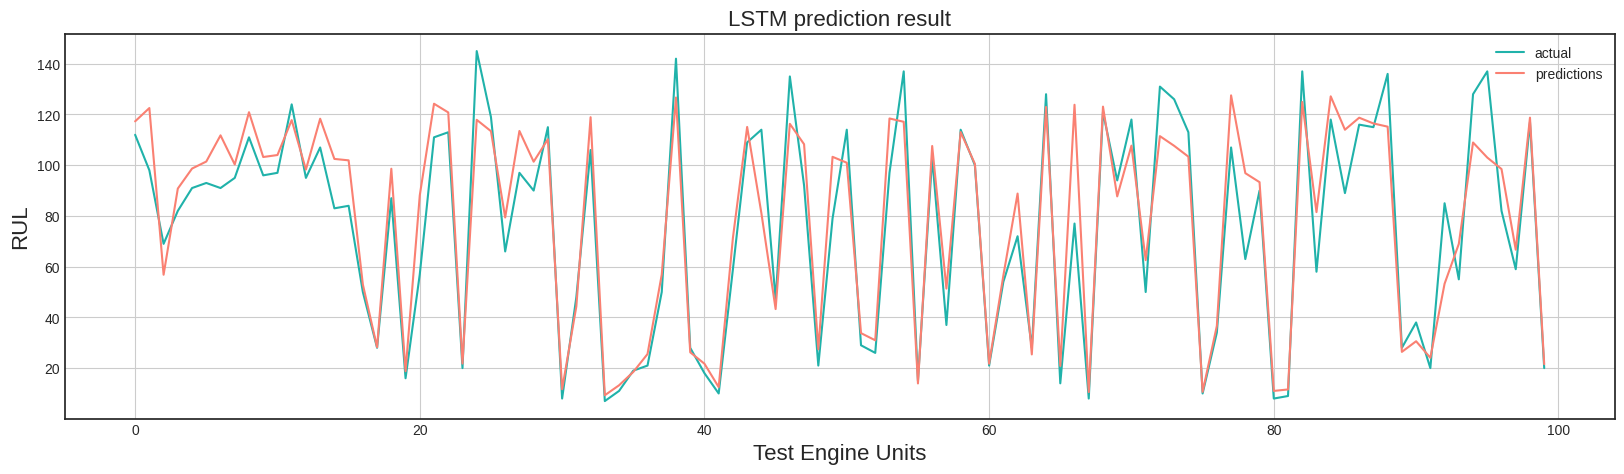

In [28]:
for model_name, model in models.items():
  rul_pred = model.predict(processed_test_data,verbose=0).reshape(-1)
  preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
  mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                              for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
  y_true = true_rul.reshape(1,len(true_rul))[0]
  plot_predActual(y_true, mean_pred_for_each_engine,model_name)
  print(' ')
